In [1]:
import osmium
import shapely.wkb as wkblib
import pandas as pd
import geopandas
import osmnx as ox
import matplotlib.pyplot as plt
import psutil

In [2]:
#uncomment and download data if you need it
!wget http://download.geofabrik.de/europe/denmark-latest.osm.pbf

--2023-03-13 14:54:54--  http://download.geofabrik.de/europe/denmark-latest.osm.pbf
Resolving download.geofabrik.de (download.geofabrik.de)... 65.109.48.72, 65.109.50.43
Connecting to download.geofabrik.de (download.geofabrik.de)|65.109.48.72|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 424910619 (405M) [application/octet-stream]
Saving to: ‘denmark-latest.osm.pbf’

denmark-latest.osm. 100%[===================>] 405.23M  86.4MB/s    in 5.5s    

2023-03-13 14:54:59 (74.3 MB/s) - ‘denmark-latest.osm.pbf’ saved [424910619/424910619]



In [ ]:
#https://max-coding.medium.com/extracting-open-street-map-osm-street-data-from-data-files-using-pyosmium-afca6eaa5d00

In [3]:
#this class creates
#multipolygons for all buildings. Uses "area", and I don't know
#if e.g. "way" or "relation" also could/should be used.
#Inspiration from here https://max-coding.medium.com/extracting-open-street-map-osm-street-data-from-data-files-using-pyosmium-afca6eaa5d00
class BuildingHandler(osmium.SimpleHandler):
    def __init__(self):
        osmium.SimpleHandler.__init__(self)
        self.building_count = 0
        self.buildings = []
        # A global factory that creates WKB from a osmium geometry
        self.wkbfab = osmium.geom.WKBFactory()

    def area(self, w):
        if w.tags.get("building") == 'yes':
            try:
                wkb = self.wkbfab.create_multipolygon(w)
                geo = wkblib.loads(wkb, hex=True)
            except Exception as e:
                print(e)
                return
            row = { "w_id": w.id, "geometry": geo }

            for key, value in w.tags:
                row[key] = value

            self.buildings.append(row)
            self.building_count += 1

In [4]:
#this runs the actual loading from the file, might take a while
buildinghandler = BuildingHandler()
buildinghandler.apply_file("denmark-latest.osm.pbf", locations=True)

invalid area (area_id=2137954400)


In [5]:
len(buildinghandler.buildings)

3302226

In [6]:
psutil.virtual_memory().percent

12.8

In [43]:
#first to a pandas dataframe and then to geopandas
df = pd.DataFrame(buildinghandler.buildings[:100000])
gdf = geopandas.GeoDataFrame(df, geometry='geometry')
gdf = gdf.set_crs("EPSG:4326")
gdf = ox.project_gdf(gdf)

In [49]:
#dropping all buildings that don't have level information
gdf = gdf.dropna(subset=['building:levels'])
gdf.shape

(3056, 410)

In [62]:
#taking a look at the mean levels
gdf['building:levels'].astype(float).mean()

2.919011780104712

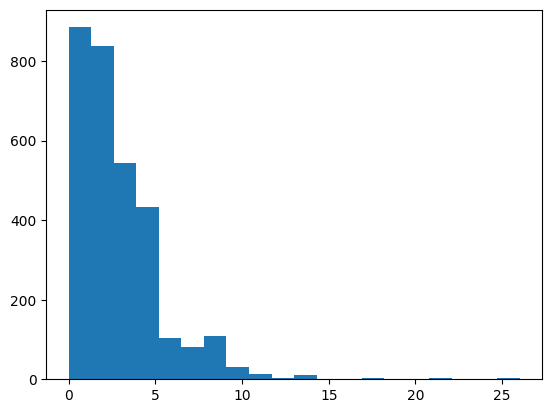

In [161]:
#taking a look at the building levels in the 100000 building sample
plt.hist(gdf['building:levels'].astype(float), bins=20)
plt.show()

In [78]:
#if one wants to store a gdf, this is how you do it
#gdf.to_file('datafram.shp')

/tmp/ipykernel_2616/2662106380.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('datafram.shp')


In [84]:
#learning new stuff about the projection
gdf.crs

<Derived Projected CRS: +proj=utm +zone=33 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [85]:
#testing filtering out the Stockholm region using the cx-function
gdf_s = gdf.cx[636513:711110, 6618371:6565834]

In [7]:
i = 200000
while i < len(buildinghandler.buildings):
    dfx = pd.DataFrame(buildinghandler.buildings[(i-200000):min([i, len(buildinghandler.buildings)-1])])
    gdfx = geopandas.GeoDataFrame(dfx, geometry='geometry')
    gdfx = gdfx.set_crs("EPSG:4326")
    gdfx = ox.project_gdf(gdfx)
    gdfx = gdfx.dropna(subset=['building:levels'])
    gdfx = gdfx[['w_id', 'geometry', 'building:levels']]
    if i < 200001:
        meta = gdfx
    else:
        meta = pd.concat([meta, gdfx])
    print(meta.shape)
    i += 200000

(851, 3)
(1243, 3)
(2306, 3)
(3193, 3)
(4231, 3)
(5245, 3)
(5378, 3)
(5405, 3)
(5842, 3)
(6159, 3)
(7212, 3)
(7251, 3)
(7345, 3)
(7443, 3)
(7506, 3)
(7673, 3)


In [8]:
#meta['floorarea'] = meta.area * meta['building:levels'].astype(float)
meta = meta[meta['building:levels'].str.contains('[A-Za-z]') == False]

In [9]:
meta = meta[meta['building:levels'].str.contains('[;-]') == False]
meta.shape

(7673, 3)

In [10]:
meta['floorarea'] = meta.area * meta['building:levels'].astype(float)

In [11]:
meta['ratio'] = meta['floorarea'].astype(float) / meta.area

In [12]:
meta['ratio'].mean()

1.3795777401277205

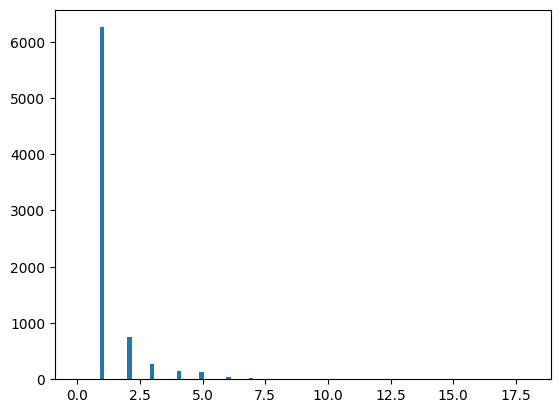

In [13]:
plt.hist(meta['ratio'], bins=100)
plt.show()

In [14]:
meta['ratio'].max()

18.0

In [15]:
meta[meta['ratio'] > 10].shape

(16, 5)

In [17]:
meta[meta['ratio'] > 10]

,w_id,geometry,building:levels,floorarea,ratio
4,28620146,"MULTIPOLYGON (((724690.096 6174949.379, 724711...",11,31821.080247,11.0
728,52722656,"MULTIPOLYGON (((718992.757 6180126.255, 719002...",13,2691.602867,13.0
2890,135056936,"MULTIPOLYGON (((724262.223 6174776.390, 724264...",13,12689.998244,13.0
2893,135056956,"MULTIPOLYGON (((724255.247 6174657.554, 724276...",12,25363.170155,12.0
147043,264984378,"MULTIPOLYGON (((725234.766 6176001.878, 725243...",17,31461.550323,17.0
147350,265360336,"MULTIPOLYGON (((725350.695 6176143.447, 725353...",13,10830.944802,13.0
147353,265360342,"MULTIPOLYGON (((725339.122 6176103.352, 725341...",13,12678.705547,13.0
147357,265360352,"MULTIPOLYGON (((725327.730 6176138.802, 725339...",12,9957.984179,12.0
147359,265360726,"MULTIPOLYGON (((725230.946 6176045.169, 725236...",13,5647.803372,13.0
147368,265362332,"MULTIPOLYGON (((725147.047 6176015.129, 725154...",14,8786.928674,14.0
